# Homework 2 
## Building a Machine Learning Model
### Purpose:
The purpose of this notebook is to practice building a regression model using the data provided by Kaggle in the House Prices: Advanced Regression challenge in order to predict house prices. 

# Table of Contents
1. Importing Data

2. Visualizing & Cleaning Data

3. Feature Engineering

4. Model Selection & Hyperparameter Tuning

5. Prediciton and Submission

6. Evaluation

In [101]:
#Import libraries to visualize and clean data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm, skew #for some statistics
import time
from sklearn.preprocessing import LabelEncoder, RobustScaler

#Silencing deprication warnings
import warnings
warnings.filterwarnings("ignore")

#Import libraries for modeling and validation
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline

#Import libraries for stacking 
from mlens.metrics.metrics import rmse
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner

# Importing Data

In [102]:
#Get the train and test data and merge them into one dataframe
train = pd.read_csv(r"C:\Users\nelso\OneDrive\Machine_Learning\Homeworks\HW2\Housing_Prices_Data\train.csv")
test = pd.read_csv(r"C:\Users\nelso\OneDrive\Machine_Learning\Homeworks\HW2\Housing_Prices_Data\test.csv")
Id = test.Id
train.shape[0]

1460

In [103]:
#Make sure the data read in okay
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Visualizing & Cleaning Data

It looks like all of our data was read in just fine. First, we are going to visualize our data and see what we are working with. We are going to start by looking at our target variable, the sale price. Let's look at the distribution of the sale prices for the data we are working with.

So it looks like our sales prices are not exactly normally distributed and are definitely skewed to the right. That is something we should definitely fix.

Now that we fixed the normality, we are going to assign our target variable as our y variable and then look at some of the other variables and how they relate to sales price. This is going to be done using a correlation heatmap. Currently we have 80 different variables. That is a lot of variables to deal with at once. So for now, we are going to take the 20 variables most correlated with sales price and look at them.

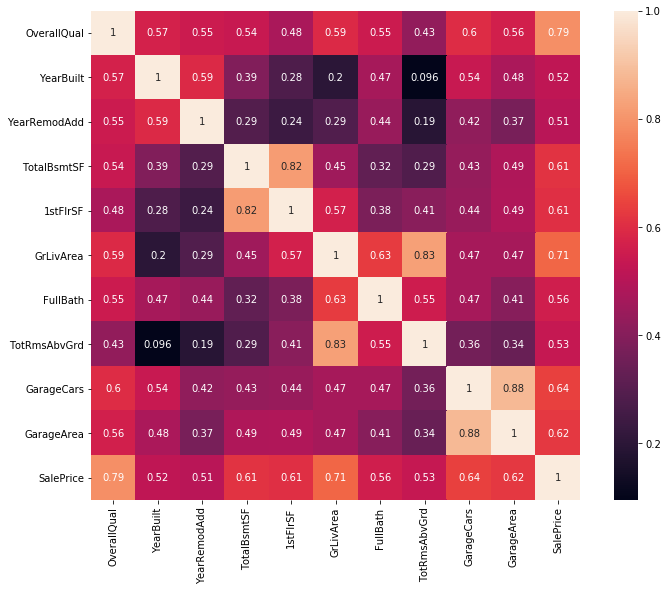

In [104]:
#Create a new set of correlation data. 
corr_train = train.corr()
#Select the 20 variables most correlated with sales price and show a heat map.
best_corr = corr_train.index[abs(corr_train["SalePrice"])>0.5]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[best_corr].corr(), square = True, annot = True)

In the correlation heat map we get some important information. First, we can see what variables are most highly correlated with the Sale Price. We see that the OverallQual, GrLivArea, and GarageCars are the three most correlated variables with sale price. Another thing we see is that some of the variables are correlated with each other. We may not want to use all of these variables in the future doing our prediction because of the colinearity between them. 

Right now we are going to dive in a little more with the three variables above that are most correlated with the price.

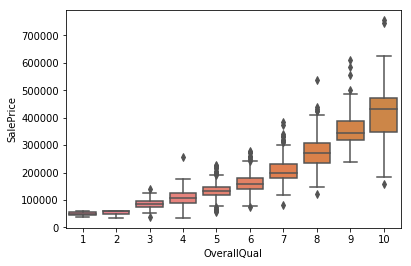

In [105]:
#Overall Quality boxplot
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = train)

From here we can see mostly what we might expect. We find that the higher the quality of a house, the more expensive it gets. And while there are a few observations outside of the whiskers, it doesn't look like there are any very significant outliers to worry about.

(1460, 81)


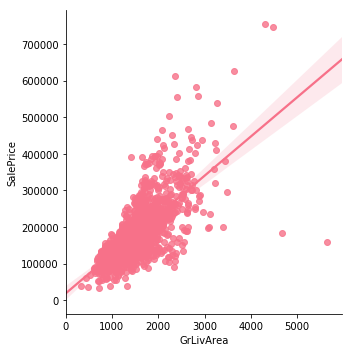

In [106]:
#Scatterplot looking at GrLivArea
print(train.shape)
sns.lmplot(x = 'GrLivArea', y = 'SalePrice', data = train)

Here we are looking mostly linear again although it looks like it might be following a little bit of an exponential path. There are also a few outliers that may throw off our predictions a little bit. We are going to get rid of those and then look at one more plot.

(1458, 81)


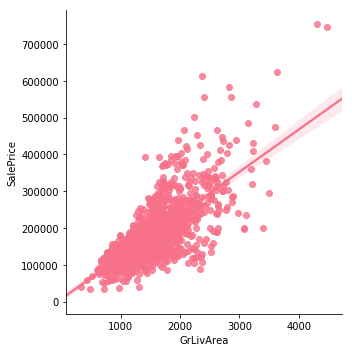

In [107]:
#Drop outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
print(train.shape)
sns.lmplot(x = 'GrLivArea', y = 'SalePrice', data = train)

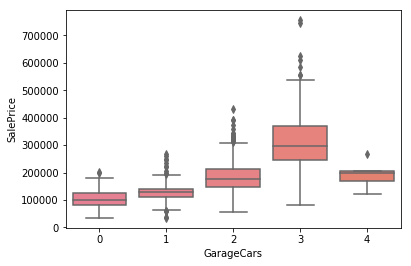

In [108]:
#Boxplot for GarageCars
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = train)

Once again we find mostly what we probably expected. The price trends upward as garages hold more cars until we get to the 4 car garages. 

So now we have a feel for which variables are the most important for the price of the houses and the relationships between those variables and our target variable. Next, we are going to check for missing variables and decide what to do with those. 

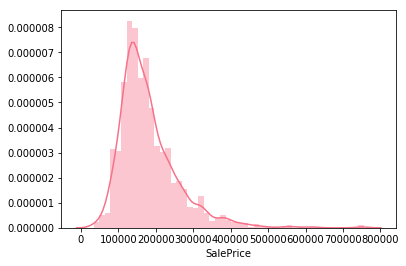

In [109]:
#Look at histogram of SalePrice
sns.distplot(train.SalePrice)

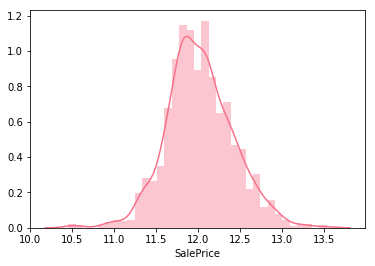

In [110]:
#Log transformation and graph again to show fixed distribution
train.SalePrice = np.log1p(train.SalePrice)
sns.distplot(train.SalePrice)

In [111]:
y = train.SalePrice
n_train = train.shape[0]
data = pd.concat((train.drop('SalePrice', axis = 1), test)).reset_index(drop = True)
data = data.drop('Id', axis = 1)
data.shape

(2917, 79)

Text(0.5,1,'Percent missing data by feature')

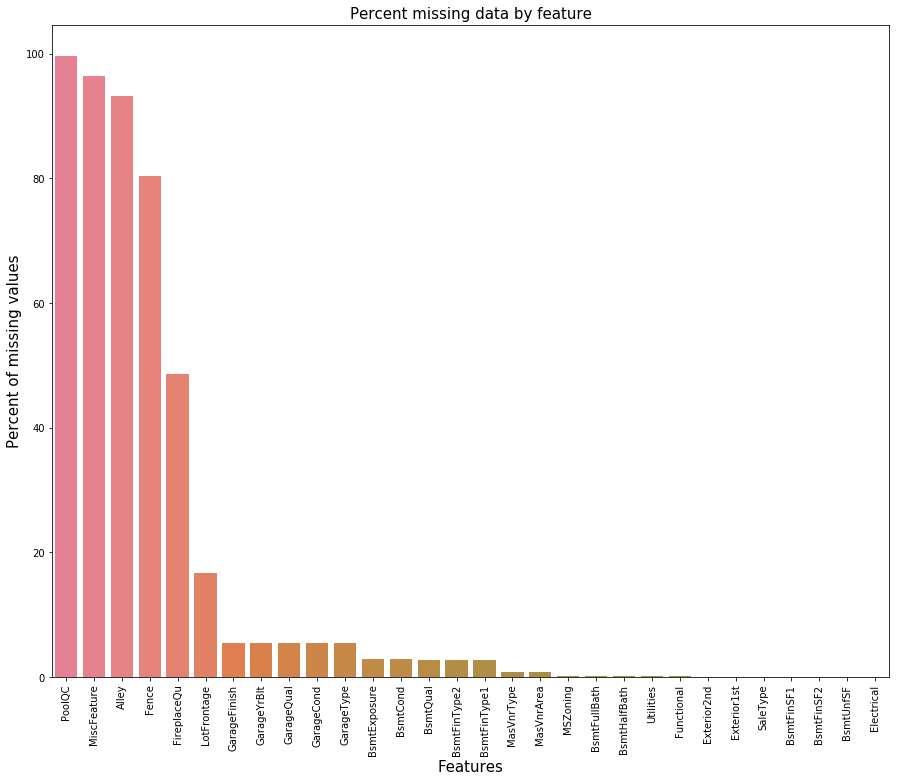

In [112]:
#Check to see missing values
#data.isna().sum().sort_values(ascending = False)[:35]
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y = data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

The good news about a lot of our missing variables, is that in our data description it tells us that a lot of these missing values simply mean that those features do not exist at the house. So first, we are going to go ahead and fill all the categorical variables that this applies to with "None" and all of the numeric variables with 0. Then we will move on to some of the other ones. 

In [113]:
data = data.drop('PoolQC', axis = 1)

In [114]:
#Use a for loop to quickly fill in the missing values for all of the categorical variables that don't exist
cat_missing = ['MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
              'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', "MasVnrType",
               'MSSubClass']
for col in cat_missing:
    data[col] = data[col].fillna('None')

In [115]:
#Use a for loop to fill in the missing values for numerical variables
num_missing = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'GarageCars',
               'GarageArea', 'GarageYrBlt']
for col in num_missing:
    data[col] = data[col].fillna(0)

So now we have taken care of some of the easier to fix missing values in our data. Now we are going to look at something that is going to take a little more of our time to correct.

We are going to look at lot frontage and figure out the best way to impute the missing values. When reading the description of the variable, it is the linear feet of street connected to the property. We can assume this will be somewhat related to the lot area. We can impute the missing values by grouping houses in categories based on lot area and use the medians of the different groups to fill in the missing values accordingly.

In [116]:
#Assign each bin a number, compute the median lot frontLotArea, and use that to impute missing values for both train and test
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

There are still a few more missing values in different columns. We are just going to fill in the most common value and not worry too much about what happens with them.

In [117]:
fill_mode = ['MSZoning', 'Utilities', 'SaleType', 'Exterior1st', 'Electrical', 'Exterior2nd']
for col in fill_mode:
    data[col] = data[col].fillna(data[col].mode()[0])

In [118]:
data["Functional"] = data["Functional"].fillna("Typ")
data = data.drop('Utilities', axis = 1)
data['KitchenQual'] = data['KitchenQual'].fillna("TA")

In [119]:
#Check for any more missing values
data.isnull().any().sum()

0

In [120]:
#Create new variable for total square footage
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath']) + data['BsmtFullBath'] + (0.5*data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

Great! We filled in all of our missing values. Now we just have a few little final changes to make before our data is ready to be used to build a model. We are going to make sure that all of our variables are in a form that the machine learning algorithms can use. We are going to do that by enconding categorical variables that have some sort of hierarchy and getting dummy variables for all of the other categorical variables and making sure each column is the right data type.

To do this let's first look at what our variable types are and decide which ones might be right for each type of transformation. We are going to do this by going to the explanation of the data an reviewing all of the variables. We will pull out most of them that refer to the condition or quality of the houses.

In [121]:
#Change month and year to categorical features; also the condition of the house
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
data['OverallCond'] = data['OverallCond'].astype(str)
data['MSSubClass'] = data['MSSubClass'].apply(str)

#Label Encoder for categorical variables with order (such as those that are ranked 1-10)
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
for i in cols:
        lbl = LabelEncoder()
        lbl.fit(list(data[i].values)) 
        data[i] = lbl.transform(list(data[i].values))

In [122]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [123]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data[feat] = boxcox1p(data[feat], lam)

There are 60 skewed numerical features to Box Cox transform


In [124]:
#Get dummy variables
data = pd.get_dummies(data)
data.shape

(2917, 221)

It looks like our data is cleaned now and ready to be used. We are going to seperate all of our data back into our training and test sets and begin to explore which models could be most useful for predicting.


# Model Selection & Hyperparameter Tuning

First we are going to split all of our data back into our train and test data sets. Then we are going to set up our scoring metric. Since we are using the RMSE (the square root of the mean squared error), we will write a function to provide us with that score.

In [125]:
x = data[:n_train]
test = data[n_train:]
test.shape

(1459, 221)

In [126]:
#Define scoring for our models
def get_rmse(model, x, y):
    scores = np.sqrt(-cross_val_score(model, x, y, cv = 5, scoring = 'neg_mean_squared_error'))
    return scores.mean()

Now it is time to decide which model we want to use to predict our house prices. We are going to use cross validation to preview a few of them and see which ones tend to do a better job predicting before anything is tuned.

Let's understand what the models are we are looking at:

Elastic Net:

Lasso:

Bayesian Ridge:

Random Forest:

Extra Trees:

XGBoost:

SVR:

LightGB:



In [127]:
#Loop through models and compare results
en = ElasticNet(alpha = .0009)
lr = Lasso(alpha = .0005)
br = BayesianRidge()
rf = RandomForestRegressor()
xgbm = XGBRegressor()
svr = SVR()
lgbm = lgb.LGBMRegressor()
knn = KNeighborsRegressor()
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
gb = GradientBoostingRegressor()
reg = [en, lr, br, rf, xgbm, svr, lgbm, knn, krr, gb]
#Use cross validation with the root mean squared error to get an idea of which models will work best for this problem
for model in reg:
    scores = get_rmse(model, x, y)
    print(model.__class__.__name__,": RMSE =", scores)

ElasticNet : RMSE = 0.11335545161121605
Lasso : RMSE = 0.11330341480075234
BayesianRidge : RMSE = 0.11610204479158001
RandomForestRegressor : RMSE = 0.14569714555611818
XGBRegressor : RMSE = 0.11937149122755712
SVR : RMSE = 0.1532967705228126
LGBMRegressor : RMSE = 0.12528293126425197
KNeighborsRegressor : RMSE = 0.24042173642169468
KernelRidge : RMSE = 0.11527762465813762
GradientBoostingRegressor : RMSE = 0.120389705019499


In [128]:
#Function for getting the best hyperparameters for each model
def tune_parameters(pipe, x, y, params, n_iter, base_model):
    orig_score = get_rmse(base_model, x, y)
    model = RandomizedSearchCV(pipe, param_distributions = params, n_iter = n_iter, cv = 5, scoring = 'neg_mean_squared_error')
    start_time = time.time()
    model.fit(x,y)
    print("--- Finding the best hyperparameters took %s seconds --- \n" % (time.time() - start_time))
    print("--- Best Hyperparameters for %s --- \n" % (pipe.named_steps.model.__class__.__name__))
    print(model.best_params_, '\n')
    model = model.best_estimator_
    new_score = get_rmse(model, x, y)
    print('----- SCORE IMPROVEMENTS ----- \n')
    print("The original RMSE was %s \n" %(orig_score))
    print("The RMSE after finding the best parameters is %s \n" %(new_score))
    print("That is an improvement of %s" %(orig_score - new_score))
    return model

In [129]:
#Create the steps for each of the model pipelines
select = SelectKBest(k = 'all')
en_steps = [('Scaler', RobustScaler()), ('feature_selection', select), ('model', en)]
lr_steps = [('Scaler', RobustScaler()), ('feature_selection', select), ('model', lr)]
xgb_steps = [('feature_selection', select), ('model', xgbm)]
lgb_steps = [('feature_selection', select), ('model', lgbm)]

#Build Pipelines
en_pipe = Pipeline(en_steps)
lr_pipe = Pipeline(lr_steps)
xgb_pipe = Pipeline(xgb_steps)
lgb_pipe = Pipeline(lgb_steps)

In [130]:
#Set up parameters for each pipeline to search through
params = {'xgb' : {'feature_selection__k' : np.arange(10,220, 10),
                  'model__n_estimators' : np.arange(100, 2000, 100),
                  'model__learning_rate' : np.arange(.01, .5, .01),
                  'model__gamma' : np.arange(0, 1, .01),
                  'model__max_depth' : np.arange(3, 10, 1),
                  'model__min_child_weight' : np.arange(0, 10, 1),
                  'model__colsample_bytree' : np.arange(.1, 1, .1)},
         'en' : {'feature_selection__k' : np.arange(10,220, 10),
                'model__l1_ratio' : np.arange(0, 1, .1),
                'model__selection' : ['cyclic', 'random']},
         'lr' : {'feature_selection__k' : np.arange(10,220, 10),
                'model__max_iter' : np.arange(700, 1400, 100),
                'model__selection' : ['cyclic', 'random']},
         'lgb' : {'feature_selection__k' : np.arange(10,220, 10),
                 'model__n_estimators' : np.arange(500, 3000, 200),
                  'model__learning_rate' : np.arange(.01, .5, .01),
                  'model__max_depth' : np.arange(3,8,1),
                  'model__colsample_bytree' : np.arange(.1, 1, .1)}
         }

In [429]:
#xgb_model = tune_parameters(xgb_pipe, x, y, params['xgb'], 50, xgb)

In [140]:
xgb_model = XGBRegressor(gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=3000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1)

In [132]:
lr_model = tune_parameters(lr_pipe, x, y, params['lr'], 100, lr)

--- Finding the best hyperparameters took 56.01331448554993 seconds --- 

--- Best Hyperparameters for Lasso --- 

{'model__selection': 'cyclic', 'model__max_iter': 900, 'feature_selection__k': 200} 

----- SCORE IMPROVEMENTS ----- 

The original RMSE was 0.11330341480075234 

The RMSE after finding the best parameters is 0.11148563388783261 

That is an improvement of 0.0018177809129197309


In [133]:
en_model = tune_parameters(en_pipe, x, y, params['en'], 100, en)

--- Finding the best hyperparameters took 58.32210922241211 seconds --- 

--- Best Hyperparameters for ElasticNet --- 

{'model__selection': 'random', 'model__l1_ratio': 0.5, 'feature_selection__k': 200} 

----- SCORE IMPROVEMENTS ----- 

The original RMSE was 0.11335545161121605 

The RMSE after finding the best parameters is 0.11162891826454942 

That is an improvement of 0.0017265333466666283


In [324]:
#lgb_model = tune_parameters(lgb_pipe, x, y, params['lgb'], 50, lgb)

In [134]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=3000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [145]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, max_iter = 1100, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0009, l1_ratio=.9, random_state=3))
gb_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [146]:
en_model = ENet.fit(x.values,y.values)
krr_model = krr.fit(x.values,y.values)
gb_model = gb_model.fit(x.values,y.values)
lr_model = lasso.fit(x.values, y.values)


In [147]:
finalMd = (np.expm1(lr_model.predict(test.values)) + np.expm1(en_model.predict(test.values)) + np.expm1(krr_model.predict(test.values)) + np.expm1(gb_model.predict(test.values)) ) / 4
finalMd

array([118772.70784886, 161893.7284795 , 186536.54534198, ...,
       171002.04476807, 113084.59775026, 224515.19854595])

In [144]:
#Scored .11584
submission = pd.DataFrame({'Id':Id,'SalePrice':finalMd})
submission.to_csv("submission.csv",index=False)

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [171]:
#Stacking
sl = SuperLearner(
    scorer = rmse,
    folds=15,
    random_state=42,
    verbose=2,
)
sl.add([en_model, krr_model, gb_model, lr_model])
sl.add([xgb_model, br_model])
sl.add_meta(lgb.LGBMRegressor())

SuperLearner(array_check=2, backend=None, folds=15,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=15, raise_on_e...221F28>)],
   n_jobs=-1, name='group-70', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function rmse at 0x00000235A0221F28>, shuffle=False,
       verbose=2)

In [ ]:
sl.fit(x_train, y_train)
preds = sl.predict(x_test)
scores = mean_squared_error(y_test, preds)
scores = np.sqrt(scores)
print(scores)


Fitting 3 layers
Processing layer-1             done | 00:02:59
Processing layer-2             done | 00:00:29
Processing layer-3             Finished loading model, total used 100 iterations
done | 00:00:00
Fit complete                        | 00:03:29
Finished loading model, total used 100 iterations

Predicting 3 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Finished loading model, total used 100 iterations
Processing layer-3             Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
done | 00:00:00
Predict complete                    | 00:00:02
0.1126703563038113


In [ ]:
sl.fit(x.values, y.values)
ens_pred = np.expm1(sl.predict(test.values))
ens_pred


Fitting 3 layers
Processing layer-1             

In [ ]:
submission = pd.DataFrame({'Id':Id,'SalePrice':ens_pred})
submission.to_csv("submission.csv",index=False)